<h1>Daten einladen</h1>

Das Notebook benutzt die pandas-Bibliothek und lädt die Daten aus dem SQLite-File. pandas und sqlite3 sollten bereits in der Python-Distribution enthalten sein, sonst können sie mit pip (bzw. pip3) nachinstalliert werden.

In [1]:
import pandas as pd
import sqlite3

Hier wird die Datenbankverbindung zu SQLite aufgebaut. Bitte achten Sie darauf, dass das Notebook im selben Verzeichnis liegt wie auch die zum Download angebotene SQLite-Datei.

In [2]:
sql = sqlite3.connect("hackernews.db")

Nun können aus der Datenbank alle Dokumente ausgelesen werden. Dieser Befehl sollte auf jeden Fall funktionieren, sonst hat etwas mit dem Download oder der Datenbankverbindung nicht geklappt.

In [3]:
docs = pd.read_sql_query("SELECT id, title FROM documents", sql, index_col="id")

# Sprache erkennen

Die Bibliothek pyfasttext kann die vortrainierten FastText Embeddings von Facebook laden. Leider trifft das für das weiter unten verwendete gensim-Paket nicht zu, weil das noch mit einem alten Format arbeitet.

In [4]:
from pyfasttext import FastText

Bitte achten Sie auch hier darauf, dass Sie das File aus dem Download in das gleiche Verzeichnis legen wie das Jupyter-Notebook.

In [5]:
lang = FastText('lid.176.bin')

Mit einfachen Texten funktioniert die Vorhersage richtig gut:

In [6]:
lang.predict_proba(["This is as test", "Hallo wie geht es dir"])

[[('en', 1.0)], [('de', 0.9844245467749922)]]

Mit Eigennamen oder speziellen Worten ist die Genauigkeit deutlich reduziert.

In [7]:
lang.predict_proba(["Marc Andreessen Says There’s No Bubble."])

[[('de', 0.3839157337436774)]]

FastText wird seinem Namen gerecht und ist wirklich sehr schnell, auf unserem Rechner nur 17,5s für 2,4 Mio Dokumente spricht für hochoptimierte Programmierung.

In [8]:
%%time
docs["lang"] = [l[0][0] if (len(l) > 0 and len(l[0]) > 1 and l[0][1] > 0.5) else "xx"  
                       for l in lang.predict_proba(docs.title)]

CPU times: user 17.2 s, sys: 141 ms, total: 17.3 s
Wall time: 17.3 s


Die Statistk des DataFrame sagt, dass Englisch die häufigste Sprache ist.

In [9]:
docs.lang.describe()

count     2447352
unique         76
top            en
freq      2090084
Name: lang, dtype: object

Pandas kann auch gruppieren und aggregieren. Hier werden die häufigsten Sprachen dargestellt. Da Englisch und unbekannt sehr überwiegt, sorgt eine logarithmische Skale für Übersicht.

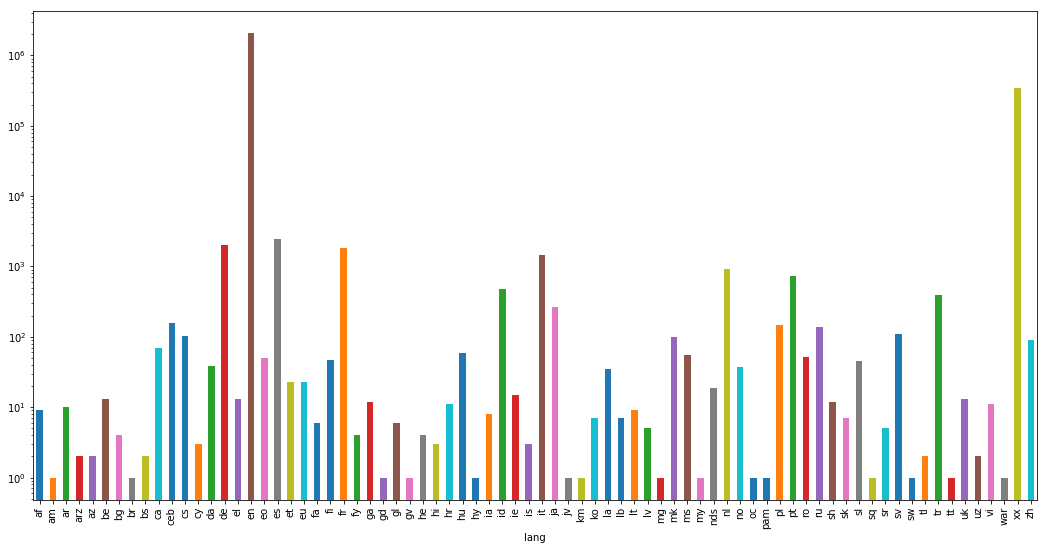

In [10]:
%matplotlib inline 
import matplotlib.pyplot as plt
docs.groupby("lang").title.agg('count').plot.bar(figsize=(18,9), logy=True);

Die Sprachdaten werden noch benötigt. Sie müssen diesen Befehl nicht ausführen, da die Tabelle in der SQLite-Datenbank schon gespeichert ist. Auch falls die Spracherkennung bei Ihnen nicht funktionieren sollte, können Sie so mit den Daten weiterarbeiten.

In [11]:
# docs.to_sql("document_languages", sql)

# NLP

Im nächsten Schritt wird die NLP-Bibliothek spaCy (weitere Informationen unter spacy.io) importiert und der englische Corpus geladen.

Es ist gut möglich, dass spaCy bei Ihnen noch nicht installiert ist, das lässt sich aber über "pip install" (bzw. "conda install") nachholen. Den Corpus müssen Sie anschließend noch herunterladen, das ist auf https://spacy.io/usage/models beschrieben und geht am besten über die Kommandozeile mit dem Befehl "python -m spacy download en_core_web_lg".

In [12]:
import spacy
nlp = spacy.load('en_core_web_lg')

In diesem Beispiel sieht man, dass NLP schon relativ viel Zeit für 1.000 Titel aus Hackernews benötigt:

In [13]:
%%time
import itertools
for i, row in docs[:1000].iterrows():
    if i % 100 == 0:
        print(i)
    doc = nlp(str(row["title"]))
    adjectives = []
    nouns = []
    verbs = []
    lemmas = []
    for token in doc:
        lemmas.append(token.lemma_)
        # adjective
        if token.pos_ == "ADJ":
            adjectives.append(token.lemma_)
        # noun
        if token.pos_ == "NOUN" or token.pos_ == "PROPN":
            nouns.append(token.lemma_)
        # verb
        if token.pos_ == "VERB":
            verbs.append(token.lemma_)

    docs.at[i, "title_lemma"] = " ".join(lemmas)
    docs.at[i, "title_nav"] = " ".join(nouns+adjectives+verbs)
    docs.at[i, "nouns"] =  ",".join(nouns)
    docs.at[i, "adjectives"] =  ",".join(adjectives)
    docs.at[i, "verbs"] =  ",".join(verbs)

100
1000
1500
1700
1800
2800
2900
CPU times: user 13.3 s, sys: 7.15 s, total: 20.4 s
Wall time: 11.3 s


spaCy kann mehrere CPUs nutzen oder auch die GPU. Dennoch dauert es lange, 2,4 Mio Artikel zu verarbeiten. Sollten Sie es ausprobieren wollen, entfernen sie einfach die "[:1000]" aus dem oberen Code und verarbeiten Sie alle Artikel.

Anschließend werden mit NLP-Informationen ergänzten Artikel in der Datenbank abgespeichert, weil sie noch mehrfach benötigt werden. Den Befehl müssen Sie nicht ausführen, in der bereitgestellten Datenbank sind bereits die NLP-Informationen enthalten.

In [14]:
# docs.to_sql("nlps", sql)

# Textstatistik

Häufig gilt das erste Interesse der zeitlichen Verteilung der Artikel. Dazu muss pandas angewiesen werden, das Zeit-Feld auch als solches zu behandeln:

In [15]:
posts_time = pd.read_sql_query("SELECT id, time FROM documents", sql, parse_dates=["time"])

Anschließend kann über die Zeit aggregiert werden und pandas kann die Dokumente zählen. Nachdem die Daten nur bis Mitte Juli 2018 reichen, sieht das letzte Quartal etwas dünn aus, hat sich aber sicher noch weiter gefüllt.

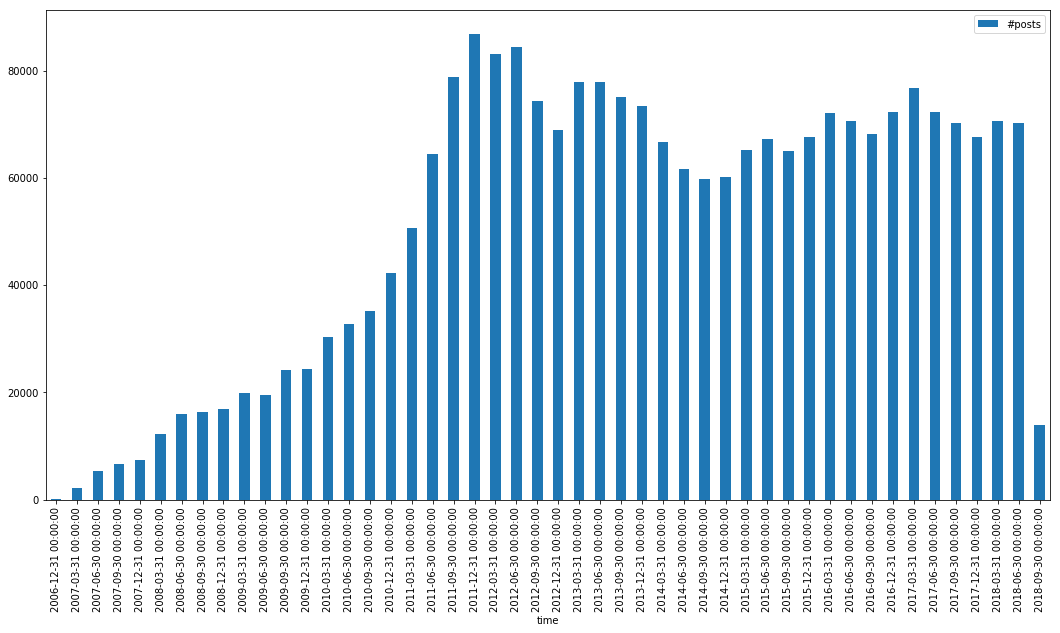

In [16]:
%matplotlib inline 
import matplotlib.pyplot as plt
import numpy as np

posts_time.set_index("time").resample('Q').\
       agg({'id': 'count'}).rename(columns={'id': '#posts'}).plot.bar(figsize=(18,9));

Für die englischsprachigen Dokumente soll nun eine Word Cloud erstellt werden. Dazu müssen diese zunächst selektiert werden. Die JOINs dienen dazu, sowohl die richtige Sprache auszuwählen als auch die entsprechenden Lemmas auszuwählen.

In [17]:
english_docs = pd.read_sql_query("SELECT d.id, title_nav, time, nouns, verbs, adjectives, points \
                                  FROM documents d, nlps n, document_languages dl\
                                  WHERE d.id=n.id AND d.id=dl.id AND (lang='en' OR lang='xx')\
                                  ORDER BY d.id", 
                                  sql, parse_dates=["time"])

Die Counter-Klasse dient in Python zum Zählen und ist für unbekannte Indizes mit 0 vorbelegt - sehr praktisch. Die unterschiedlichen Worarten werden separat gezählt.

In [18]:
from collections import Counter
nouns = Counter()
verbs = Counter()
adjectives = Counter()
for i, row in english_docs.iterrows():
    for n in row["nouns"].split(","):
        nouns[n] += 1
    for v in row["verbs"].split(","):
        verbs[v] += 1
    for a in row["adjectives"].split(","):
        adjectives[a] += 1

spaCy findet sehr viele Pronomen und kennezeichnet dieses als -PRON-. Diese werden nicht benötigt und daher aus dem Counter gelöscht.

In [19]:
# -PRON- weglassen
adjectives["-PRON-"] = 0

Nun können die Word Clouds für die unterschiedlichen Wortarten mithilfe der entsprechenden Bibliothek erzeugt werden.

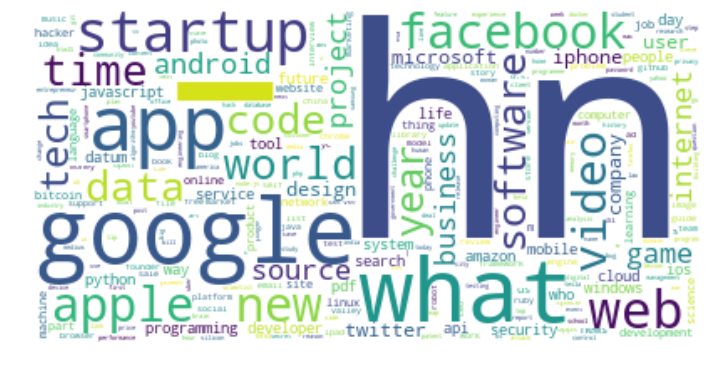

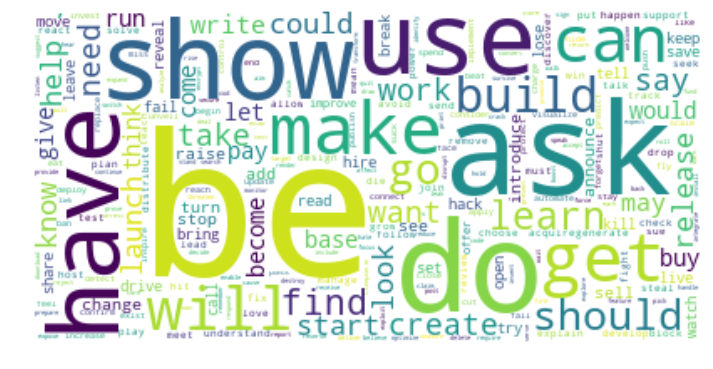

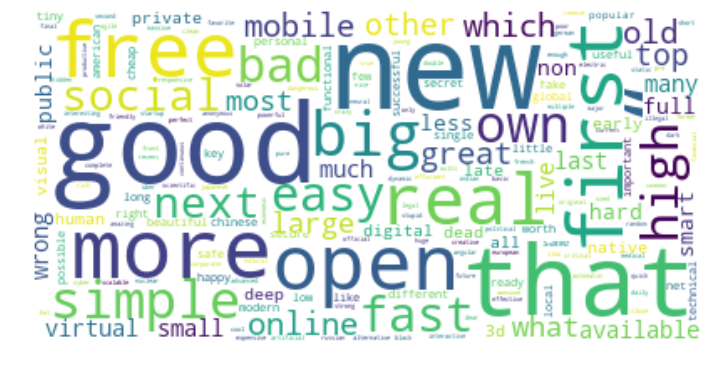

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt
from wordcloud import WordCloud

for t in [nouns, verbs, adjectives]:
    wc = WordCloud(background_color="white", max_words=1000)
    wc.generate_from_frequencies(t)
    plt.figure(figsize=(12,12))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off");


# Topic Modelling

Für das Topic Modelling bietet sich Scikit Learn (www.scikit-learn.org) an. Dort werden bereits Stoppworte bereitgestellt, allerdings kennen diese noch nicht das schon oben angesprochene -PRON-:

In [21]:
from sklearn.feature_extraction import text 
stop_words = text.ENGLISH_STOP_WORDS.union(['pron'])

Die Vektorisierung und Konvertierung in TF/IDF kann in einem Rutsch erfolgen. Hackernews hat einen sehr großen Wortvorrat, der für die weiteren Berechnungen nicht unbedingt benötigt wird und daher bei 50.000 Worten gekappt wird. Probieren Sie aus, ob Sie mit mehr oder weniger Worten andere Resultate erhalten! Achtung, bei mehr Worten wächst die Rechenzeit deutlich.

In [22]:
%%time 
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=50000, stop_words=stop_words)
vectors = tfidf.fit_transform(english_docs.title_nav.apply(str))

CPU times: user 13.7 s, sys: 308 ms, total: 14 s
Wall time: 14 s


Die Hilfsfunktion kann die Beiträge der einzelnen Features (also Worte) zu den Topics darstellen.

In [23]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

## NMF

NMF kann Topic Models sehr schnell ausrechnen:

In [24]:
%%time
from sklearn.decomposition import NMF, LatentDirichletAllocation

no_topics = 6

# Run NMF
nmf = NMF(n_components=no_topics, random_state=1, alpha=.1, l1_ratio=.5, \
          init='nndsvd').fit(vectors)

CPU times: user 1min 7s, sys: 11.4 s, total: 1min 19s
Wall time: 1min 19s


Und die sind auch gut interpretierbar!

In [25]:
no_top_words = 10
display_topics(nmf, tfidf.get_feature_names(), no_top_words)

Topic 0:
hn ask good project work job use review yc idea
Topic 1:
app web make use good build mobile apple facebook android
Topic 2:
google search chrome facebook android glass maps cloud engine microsoft
Topic 3:
startup idea tech founder work review start launch need learn
Topic 4:
new york feature year way apple release launch look facebook
Topic 5:
open source project code software free release platform data letter


## LDA

Als generatives Verfahren ist LDA deutlich langsamer.

In [26]:
%%time
lda = LatentDirichletAllocation(n_components=no_topics, max_iter=5, \
                                learning_method='online', learning_offset=50.,\
                                random_state=0).fit(vectors)

CPU times: user 28min 15s, sys: 2.87 s, total: 28min 18s
Wall time: 28min 15s


Und kommt zu völlig anderen Resultaten.

In [27]:
display_topics(lda, tfidf.get_feature_names(), no_top_words)


Topic 0:
hn ask learn good game year people ai work problem
Topic 1:
pdf time data project bitcoin datum security need code blockchain
Topic 2:
open learning source developer react create say network github social
Topic 3:
machine python tool way software life write cloud end look
Topic 4:
apple programming language facebook job linux day simple company technology
Topic 5:
javascript internet js design uber drive car use run search


# Clustering

Eine Alternative zu Topic Modelling ist Clustering. Hier wird jedes Dokument in genau einen Cluster eingeordnet. K-Means als Methode ist für Textdaten gut geeignet und etwas schneller als LDA.

In [28]:
%%time
from sklearn.cluster import KMeans
import numpy as np
np.random.seed(0)
clusters = 6
k_means_text = KMeans(n_clusters=clusters)
k_means_text.fit(vectors)

CPU times: user 18min 37s, sys: 4.15 s, total: 18min 41s
Wall time: 18min 41s


Diese Funktion dient der Darstellung der Cluster als Wordclouds. Für jeden Cluster werden die im TF/IDF-Raum führenden Features ausgerechnet.

In [29]:
%matplotlib inline
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import sys

def wordcloud_text_cluster_summary(method, matrix, vectorizer):
    labels = method.labels_
    features = vectorizer.get_feature_names()
    unique_labels, counts = np.unique(labels, return_counts=True)
    for cluster, count in zip(unique_labels, counts):
        vec = np.asarray(matrix[method.labels_ == cluster].sum(axis=0))
        sys.stdout.write("\nCluster %d with size %d: " % (cluster, count))
        # der Vektor hat zwei "Achsen", daher das zusätzliche [0] für die erste
        freq = {}
        for f in np.argsort(vec)[0][-20::][::-1]:
            v = int(vec[0,f] * 1000.0)
            if v > 0:
                freq[features[f]] = int(vec[0,f] * 1000.0)
                sys.stdout.write(features[f])
                sys.stdout.write(' ')
        wc = WordCloud(background_color="white", max_words=100)
        wc.generate_from_frequencies(freq)
        plt.figure(figsize=(12,12))
        plt.imshow(wc, interpolation='bilinear')
        plt.axis("off");
        plt.savefig("cluster-%02d.png" % cluster)
        plt.axis("off");

Auch hier kann man die Ergebnisse gut interpretieren.


Cluster 0 with size 2044503: startup use make good facebook apple video world open build time work code year hn data internet release learn design 
Cluster 1 with size 20623: developer hn ask web app software hire ios good android tool game end new apple look make mobile designer job 
Cluster 2 with size 112476: hn ask good startup use project work app yc learn job idea review company make site web service software website 
Cluster 3 with size 49704: app store mobile ios android web iphone hn build apple new google make use facebook engine launch mac create native 
Cluster 4 with size 144184: google new search york facebook apple chrome android use microsoft glass maps launch cloud feature make startup way open api 
Cluster 5 with size 63675: web free design application development hn framework online open use software apps browser service mobile site server tool new good 

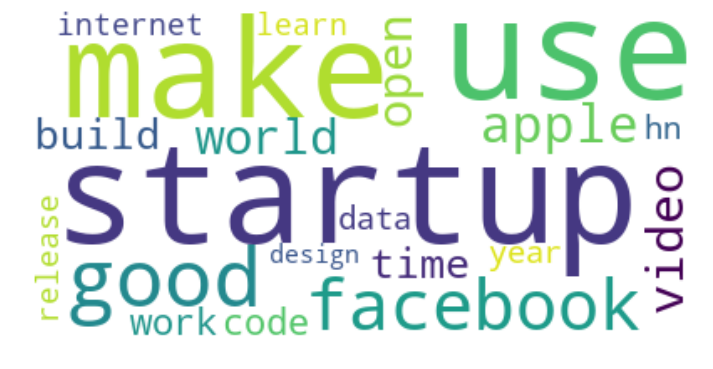

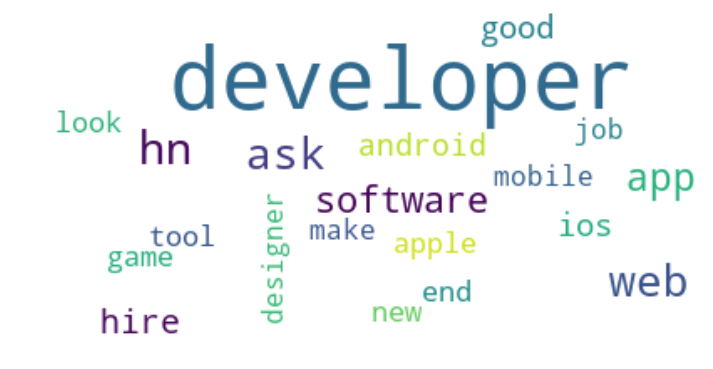

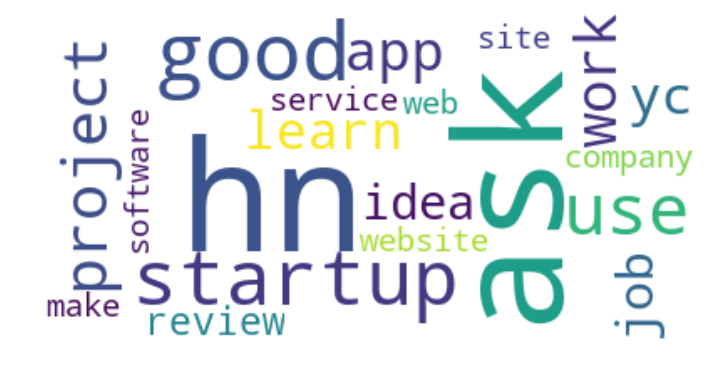

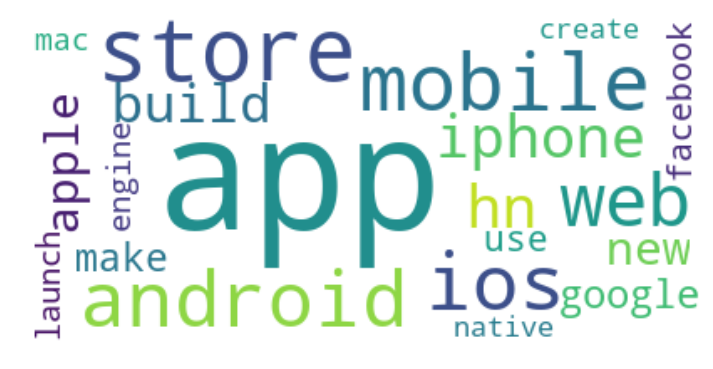

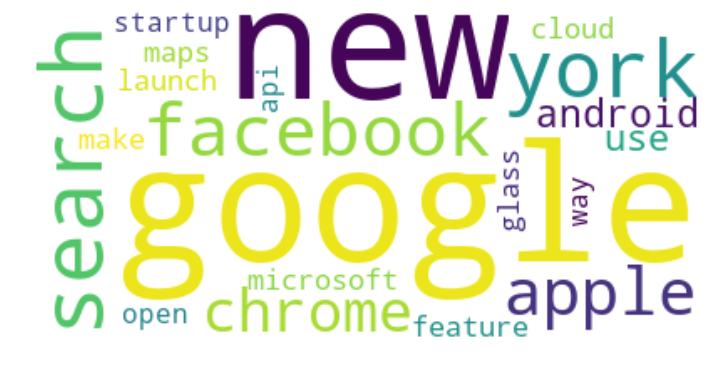

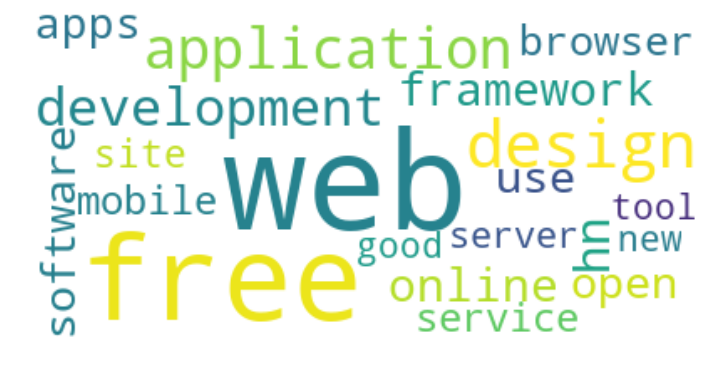

In [30]:
wordcloud_text_cluster_summary(k_means_text, vectors, tfidf)

# Supervised Learning

## Struktur der Points

Das Ziel des überwachten Lernen soll sein, aus den Headlines die Punkte zu erraten, die dafür vermutlich vergeben werden. Dazu sollte man sich zunächst einen Überblick über die Punkte verschaffen. Es gibt einige Beiträge, die sehr viele Punkte erhalten. Alles über 100 Punkte ist ohnehin schon sehr erfolgreich und wird dort gekappt:

In [31]:
english_docs.loc[english_docs.points>100, "points"]=100

Nun kann das Ergebnis visualisiert werden:

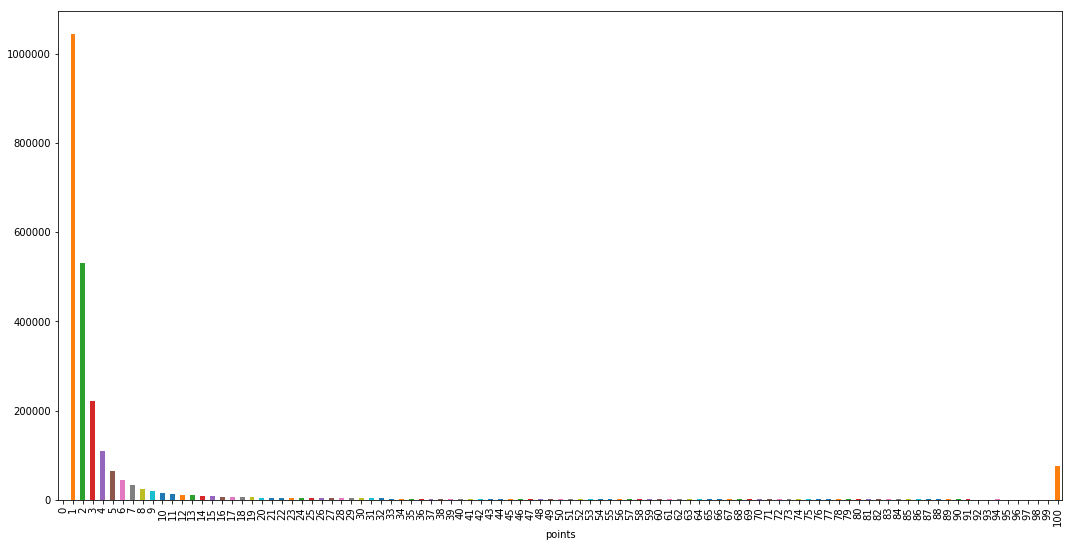

In [32]:
english_docs.groupby("points").id.agg('count').plot.bar(figsize=(18,9));

Alle Beiträge mit einem Punkt werden als wenig erfolgreich betrachtet, die zwischen 2 und 15 Punkte als mittel erfolgreich und alle andere als sehr erfolgreich. Damit sind die Werte diskretisiert und das ein Klassifikationsverfahren kann angewendet werden.

In [33]:
english_docs["category"] = "middle"
english_docs.loc[english_docs.points==1, "category"] = "low"
english_docs.loc[english_docs.points>=15, "category"] = "high"

## Training

Das Training arbeitet mit vektorisierten Daten, diese stehen von oben noch zur Verfügung.

In [34]:
%%time
from sklearn.linear_model import SGDClassifier
# mit Gradientenverfahren trainieren
clf = SGDClassifier(loss='hinge', max_iter=1000, tol=1e-3, random_state=42)
clf.fit(vectors, english_docs["category"].as_matrix())

CPU times: user 5.8 s, sys: 3.97 ms, total: 5.8 s
Wall time: 5.8 s


## Anpassung der Trainingsmenge

Leider ist die Trainingsmenge sehr ungleich verteilt, da das Gros der Artikel nur einen Punkt enthält. Dies führt zu einem "schiefen" Lernverhalten, was durch die Anpassung der Trainingsmenge kompensiert werden kann.

In [35]:
low = english_docs[english_docs.category == "low"]
middle = english_docs[english_docs.category == "middle"]
high = english_docs[english_docs.category == "high"]

Daraus wieder einen einzigen DataFrame zusammensetzen, dafür wird die maximale Sample-Größe genutzt, die noch eine Gleichverteilung zwischen den Klassen erlaubt:

In [36]:
sample = min([len(low), len(middle), len(high)])
learn = pd.concat([low.sample(sample), middle.sample(sample), high.sample(sample)])

## Training mit Split

Mit der train_test_split-Methode können Daten aufgeteilt werden in eine Trainings- und eine Testmenge.

In [37]:
from sklearn.model_selection import train_test_split
train, test, train_target, test_target = \
   train_test_split(learn.title_nav.map(str), learn["category"].as_matrix(), 
                    test_size=0.2, random_state=1)

Die Vektorisierung wird nur mit der Trainingsmenge durchgeführt:

In [38]:
%%time
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
cv_points_train = CountVectorizer(max_features=50000, stop_words=stop_words)
vectors_points_train_count = cv_points_train.fit_transform(train)
tfidf_points_train = TfidfTransformer(use_idf=True)
vectors_points_train = tfidf_points_train.fit_transform(vectors_points_train_count)

CPU times: user 3.86 s, sys: 48 ms, total: 3.91 s
Wall time: 3.91 s


Anschließend wird der Classifier trainiert.

In [39]:
%%time
clf_train = SGDClassifier(loss='hinge', max_iter=1000, tol=1e-3, random_state=42)
clf_train.fit(vectors_points_train, train_target)

CPU times: user 1.79 s, sys: 0 ns, total: 1.79 s
Wall time: 1.79 s


Nun kann der Classifier auf die Testdaten angewendet werden.

In [40]:
from sklearn import metrics
# Texte der Testmenge in TF/IDF-Vektoren wandeln
vectors_points_test_count = cv_points_train.transform(test)
vectors_points_test = tfidf_points_train.transform(vectors_points_test_count)
# Vorhersagen
predicted_points_test = clf_train.predict(vectors_points_test)

scikit-learn weiß auch, wie man die Daten auswertet und die Accuracy berechnet.

In [41]:
metrics.accuracy_score(test_target, predicted_points_test)

0.4201745900954155

Alternativ können auch Precision und Recall ermittelt werden.

In [42]:
print(metrics.classification_report(test_target, predicted_points_test))

             precision    recall  f1-score   support

       high       0.42      0.51      0.46     55707
        low       0.44      0.54      0.48     55860
     middle       0.37      0.21      0.27     55911

avg / total       0.41      0.42      0.41    167478



# Word2vec

## Modell trainieren

Für word2vec wird das gensim-Paket benötigt, bitte bei Bedarf mittels pip oder conda installieren

In [43]:
from gensim.test.utils import common_texts, get_tmpfile
from gensim.models import Word2Vec
from gensim.models import Phrases

Das Training wird für jedes Jahr separat durchgeführt und dauert relativ lang. Bitte lassen Sie sich nicht durch die Warnung verwirren, die im Moment von gensim präferierte Variante des Algorithmus ist langsamer als die hier gewählte.

In [44]:
%%time
model = {}
for y in range(2007, 2019):
    texts = [t.split(" ") for t in english_docs[english_docs.time.dt.year==y].title_nav]
    entity_transformer = Phrases(texts)
    model[y] = Word2Vec(entity_transformer[texts], min_count=1, workers=4)

/usr/local/lib/python3.6/dist-packages/gensim/models/phrases.py:494: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


CPU times: user 8min 11s, sys: 1.37 s, total: 8min 12s
Wall time: 6min 2s


## Zeitabhängige Auswertungen

Für jedes Jahr werden die 10 semantisch nächsten Begriffe zu Facebook ermittelt und in einem DataFrame zusammengefasst.

In [45]:
facebook = pd.DataFrame()
for y in range(2007, 2019):
    h = {'year': int(y)}
    for p in model[y].wv.most_similar(positive=["facebook"], topn=10):
        if p[1] > 0.8:
            h[p[0]] = p[1]
    facebook = facebook.append(h, ignore_index=True)
facebook.year = facebook.year.astype(int)

Anschließend kann dieser als Heatmap geplottet werden:

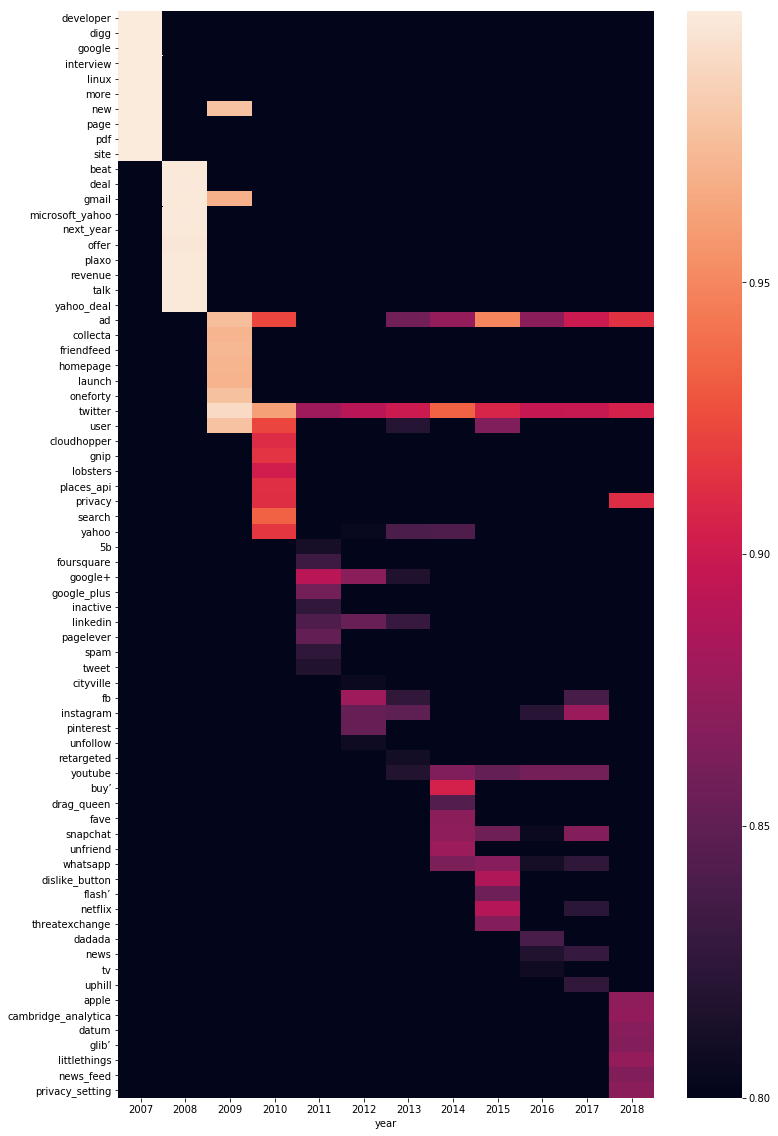

In [46]:
import seaborn as sns
plt.figure(figsize=(12,20))
ax = sns.heatmap(facebook.fillna(0).set_index(['year']).transpose(), vmin=0.8, vmax=1.0)
cbar = ax.collections[0].colorbar
cbar.set_ticks([0.8, .85, .9, .95])

## Zeitunabhängiges Beispiel

Ein Training lässt sich auch für den gesamten Corpus durchführen.

In [47]:
%%time
texts = [t.split(" ") for t in english_docs.title_nav]
model = Word2Vec(entity_transformer[texts], min_count=1, workers=4)

/usr/local/lib/python3.6/dist-packages/gensim/models/phrases.py:494: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


CPU times: user 7min 35s, sys: 1.06 s, total: 7min 36s
Wall time: 5min 15s


Die Daten lassen sich im DataFram übersichtlicher darstellen.

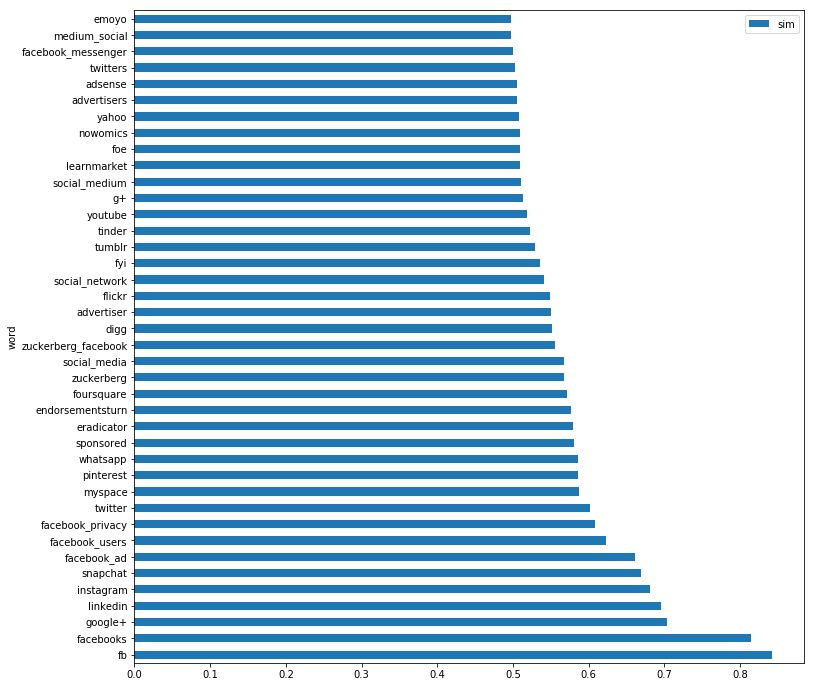

In [48]:
pd.DataFrame(model.wv.most_similar(positive=["facebook"], topn=40), columns=["word", "sim"]).\
    set_index("word").plot.barh(figsize=(12,12))